# 2. Decision Tree Ödevi (dava_sonuclari.csv)

#### → Kütüphaneler içeri aktarıldı.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

#### → dava_sonuclari.csv dosyası DataFrame'e yüklendi.

In [2]:
data = pd.read_csv('dava_sonuclari.csv')

## Görev 1 : Eksik veya Aykırı Değerleri Kontrol Edip Temizleme

#### Eksik değer kontrolü

In [3]:
print("Eksik değer kontrolü:")
eksik = data.isnull().sum()
if eksik.sum() == 0:
    print("Eksik değer yok")
else:
    print(eksik[eksik > 0])

Eksik değer kontrolü:
Eksik değer yok


#### Outcome kontrolü

In [4]:
print("Outcome (Hedef Değişken) Analizi:")
outcome_dagilim = data['Outcome'].value_counts()
print(outcome_dagilim)
print(f"Benzersiz değerler: {data['Outcome'].unique()}")
if len(data['Outcome'].unique()) == 1:
    print("Outcome sütununda sadece TEK SINIF (0 - Kaybedilen) var.")

Outcome (Hedef Değişken) Analizi:
Outcome
0    200
Name: count, dtype: int64
Benzersiz değerler: [0]
Outcome sütununda sadece TEK SINIF (0 - Kaybedilen) var.


#### Case Type kategorik değişkenini sayısal değere dönüştürme

In [5]:
le = LabelEncoder()
if 'Case Type' in data.columns:
    data['Case Type Encoded'] = le.fit_transform(data['Case Type'])
    print("Case Type Sayısal Değişkene Dönüşümü:")
    for i, case_type in enumerate(le.classes_):
        print(f"{case_type}:{i}")

Case Type Sayısal Değişkene Dönüşümü:
Civil:0
Commercial:1
Criminal:2


#### Özellik seçimi

In [6]:
ozellik_sutunlari = [col for col in data.columns if col not in ['Outcome', 'Case Type']]
if 'Case Type Encoded' in data.columns:
    ozellik_sutunlari.append('Case Type Encoded')
X = data[ozellik_sutunlari]
y_orijinal = data['Outcome']
print(f"Kullanılan özellikler ({len(ozellik_sutunlari)} adet):")
for i, col in enumerate(ozellik_sutunlari, 1):
    print(f"  {i}. {col}")

Kullanılan özellikler (12 adet):
  1. Case Duration (Days)
  2. Judge Experience (Years)
  3. Number of Witnesses
  4. Legal Fees (USD)
  5. Plaintiff's Reputation
  6. Defendant's Wealth (USD)
  7. Number of Evidence Items
  8. Number of Legal Precedents
  9. Settlement Offered (USD)
  10. Severity
  11. Case Type Encoded
  12. Case Type Encoded


### Solation Forest İle Farklı Davaların Tespiti

#### Bu kodda "tek sınıflı öğrenme" (one-class learning) yaklaşımı kullanıldı:
##### Problem :
dava.sonuclari.csv dosyasında sadece kaybedilen davalar (0) olması.
##### Kullanılan Çözüm Yolu :
Isolation Forest ile 'normal desen'den sapanlar bulundu. Bu sapmalar 'potansiyel kazanılabilir davalar' olarak işaretlendi. Decision Tree ile hangi özelliklerin bu sapmalara yol açtığını analiz edildi.


##### Anomali tespitinde yaygın contamination değeri belirleme : İstatistiksel Genel Kural

0.01-0.05 : Çok nadir anomaliler

0.10-0.20: Makul sayıda farklı örnek

0.30+ : Çok fazla farklılık

#### Yeni hedef değişken oluşturma

-1 (anomali) → 1 (potansiyel kazanılabilir)

1 (normal) → 0 (kaybetme)

In [7]:
anomali_orani = 0.15  # Verinin %15'i farklı
iso_forest = IsolationForest(contamination=anomali_orani,random_state=42,n_estimators=100)
# Anomali skorları hesapla (-1: anomali/farklı, 1: normal)
anomali_etiket = iso_forest.fit_predict(X)
anomali_skor = iso_forest.score_samples(X)

In [8]:
y_sentetik = np.where(anomali_etiket == -1, 1, 0)
data['Potential_Win'] = y_sentetik
data['Anomaly_Score'] = anomali_skor
print(f"Tespit Sonuçları:")
print(f"Normal davalar (0): {(y_sentetik == 0).sum()} adet (%{(y_sentetik == 0).sum() / len(y_sentetik) * 100:.1f})")
print(f"Potansiyel kazanılabilir (1): {(y_sentetik == 1).sum()} adet (%{(y_sentetik == 1).sum() / len(y_sentetik) * 100:.1f})")
print("Yorum: Isolation Forest, 'kaybedilen davalar' kalıbından sapan davaları 'potansiyel kazanılabilir' olarak işaretledi.")

Tespit Sonuçları:
Normal davalar (0): 170 adet (%85.0)
Potansiyel kazanılabilir (1): 30 adet (%15.0)
Yorum: Isolation Forest, 'kaybedilen davalar' kalıbından sapan davaları 'potansiyel kazanılabilir' olarak işaretledi.


#### Örnek Kazanılma Potansiyeli Yüksek Davalar

In [9]:
potensiyel = data[data['Potential_Win'] == 1].sort_values('Anomaly_Score')
print(f"Toplam {len(potensiyel)} potansiyel kazanılabilir dava tespit edildi.")
print("İlk 5 Örnek (En farklı olan davalar):")
print(potensiyel[ozellik_sutunlari[:5]].head())

Toplam 30 potansiyel kazanılabilir dava tespit edildi.
İlk 5 Örnek (En farklı olan davalar):
     Case Duration (Days)  Judge Experience (Years)  Number of Witnesses  \
188                   339                        22                   19   
67                    274                         5                    1   
63                     96                        24                    1   
105                   102                        31                    2   
9                      42                        35                    5   

     Legal Fees (USD)  Plaintiff's Reputation  
188              5915                       1  
67              38609                       3  
63              19603                       3  
105              6851                       1  
9                8071                       3  


## Görev 2 : Veriyi Eğitim (%80) ve Test (%20) Olarak Ayırma

#### Özellik (X) ve hedef (y) değişkenleri ayrılacak.
Outcome sütunu, modelin tahmin edeceği hedef değişkendir. (0: Kaybetmek, 1: Kazanmak)

"Case Type" (dava türü) kategorik olduğu için sayısal versiyonu olan "Case Type Encoded" kullanılacak.

#### Veriyi Eğitim ve Test Serisine Ayırma
test_size=0.2 → verinin %20’si test için ayrılır

stratify=y → dağılım korunur (dengesiz veri için)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sentetik, test_size=0.2, random_state=42, stratify=y_sentetik)
print(f"Veri Bölünmesi:")
print(f"Eğitim seti: {X_train.shape[0]} örnek")
print(f"Test seti: {X_test.shape[0]} örnek")

Veri Bölünmesi:
Eğitim seti: 160 örnek
Test seti: 40 örnek


## Görev 3:	Decision Tree Modelini Kurup Eğitme

#### Model Kurulumu (Karar Ağacı Modeli)

In [11]:
dt_model = DecisionTreeClassifier(max_depth=5,min_samples_split=10,min_samples_leaf=5,random_state=42)
dt_model.fit(X_train, y_train)

# Tahminler
y_train_tahmin = dt_model.predict(X_train)
y_test_tahmin = dt_model.predict(X_test)
print("Model eğitildi!")


Model eğitildi!


## Görev 4 : Test Verilerini Kullanarak Modelin Doğruluğunu Değerlendirme. (Model Performansı)
### Accuracy, Precision, Recall, F1-Score Gibi Metrikleri Hesaplama
Accuracy (Doğruluk): Modelin tüm tahminler içinde doğru olanların oranıdır.

Precision (Kesinlik): Modelin “pozitif” dediği tahminlerden kaç tanesinin gerçekten pozitif olduğunu gösterir.
(Tespit ettiği kazanılabilir davaların ne kadarı gerçekten farklı?)

Recall (Duyarlılık / Sensitivite): Gerçekte pozitif olan örneklerin kaçını modelin doğru tahmin ettiğini gösterir.
(Tüm farklı davaların ne kadarını yakaladık?)

F1-Score: Precision ve Recall’un dengeli ortalamasıdır; hem yanlış pozitifleri hem de yanlış negatifleri hesaba katar.

In [12]:
train_acc = accuracy_score(y_train, y_train_tahmin)
test_acc = accuracy_score(y_test, y_test_tahmin)
precision = precision_score(y_test, y_test_tahmin)
recall = recall_score(y_test, y_test_tahmin) # (Tüm farklı davaların ne kadarını yakaladık?)
f1 = f1_score(y_test, y_test_tahmin)
print("Metrikler:")
print(f"Eğitim Doğruluğu: {train_acc:.2%}")
print(f"Test Doğruluğu: {test_acc:.2%}")
print(f"Precision (Kesinlik): {precision:.2%}")
print(f"Recall (Duyarlılık): {recall:.2%}")
print(f"F1-Score: {f1:.2%}")
print(f"Detaylı Rapor:")
print(classification_report(y_test, y_test_tahmin,target_names=['Kaybedilebilir', 'Kazanılabilir']))


Metrikler:
Eğitim Doğruluğu: 90.62%
Test Doğruluğu: 92.50%
Precision (Kesinlik): 100.00%
Recall (Duyarlılık): 50.00%
F1-Score: 66.67%
Detaylı Rapor:
                precision    recall  f1-score   support

Kaybedilebilir       0.92      1.00      0.96        34
 Kazanılabilir       1.00      0.50      0.67         6

      accuracy                           0.93        40
     macro avg       0.96      0.75      0.81        40
  weighted avg       0.93      0.93      0.91        40



#### Karmaşıklık Matrisi

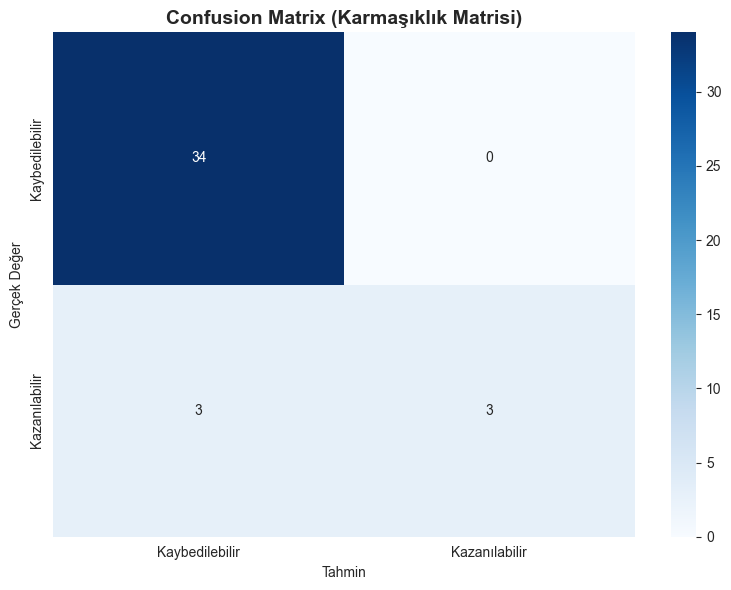

In [13]:
# Karmaşıklık Matrisi
cm = confusion_matrix(y_test, y_test_tahmin)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Kaybedilebilir', 'Kazanılabilir'],
            yticklabels=['Kaybedilebilir', 'Kazanılabilir'])
plt.title('Confusion Matrix (Karmaşıklık Matrisi)', fontsize=14, weight='bold')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.tight_layout()
plt.show()


## Görev 5 : Karar Ağacını Görselleştirip Hangi Özelliklerin Daha Etkili Olduğunu Yorumlama

#### Hangi Özelliklerin Kazanma Potansiyelini Belirlediğini Tespit Etme

In [14]:
ozellik_onemi= pd.DataFrame({'Özellik': X.columns,'Önem': dt_model.feature_importances_}).sort_values('Önem', ascending=False)
print("Özellik Önem Sıralaması:")
for idx, row in ozellik_onemi.iterrows():
    if row['Önem'] > 0:
        print(f"{row['Özellik']:.<40} {row['Önem']:.5f}")

Özellik Önem Sıralaması:
Number of Evidence Items................ 0.37212
Defendant's Wealth (USD)................ 0.30520
Legal Fees (USD)........................ 0.14370
Plaintiff's Reputation.................. 0.14187
Case Duration (Days).................... 0.03712


#### Hangi Özelliklerin Kazanma Potansiyelini Belirlediğini Görselleştirme

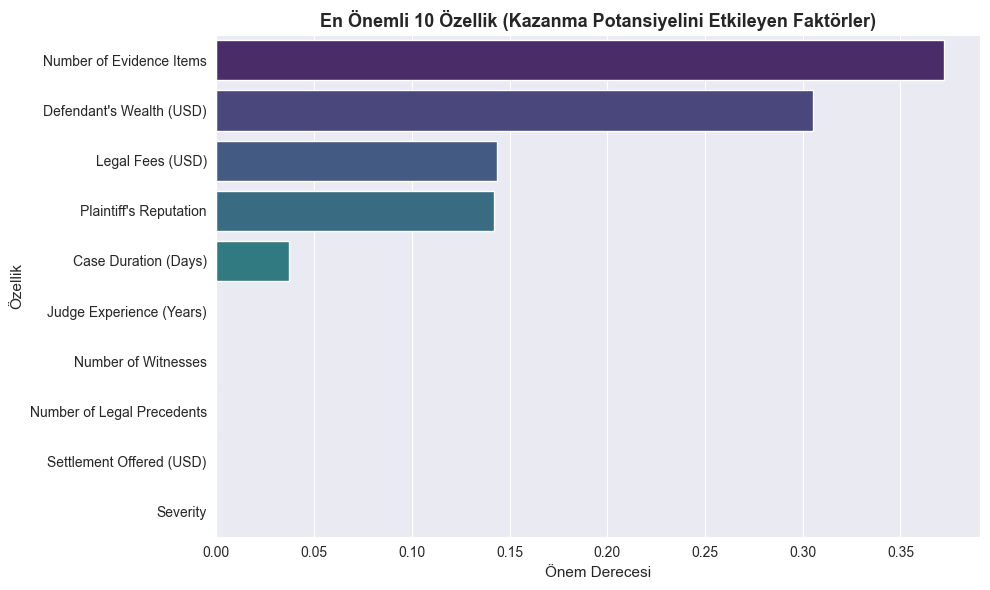

In [16]:
plt.figure(figsize=(10, 6))
top_ozellikler= ozellik_onemi.head(10)
sns.barplot(data=top_ozellikler, y='Özellik', x='Önem', palette='viridis')
plt.title('En Önemli 10 Özellik (Kazanma Potansiyelini Etkileyen Faktörler)',fontsize=13, weight='bold')
plt.xlabel('Önem Derecesi', fontsize=11)
plt.ylabel('Özellik', fontsize=11)
plt.tight_layout()
plt.show()

### Karar Ağacı

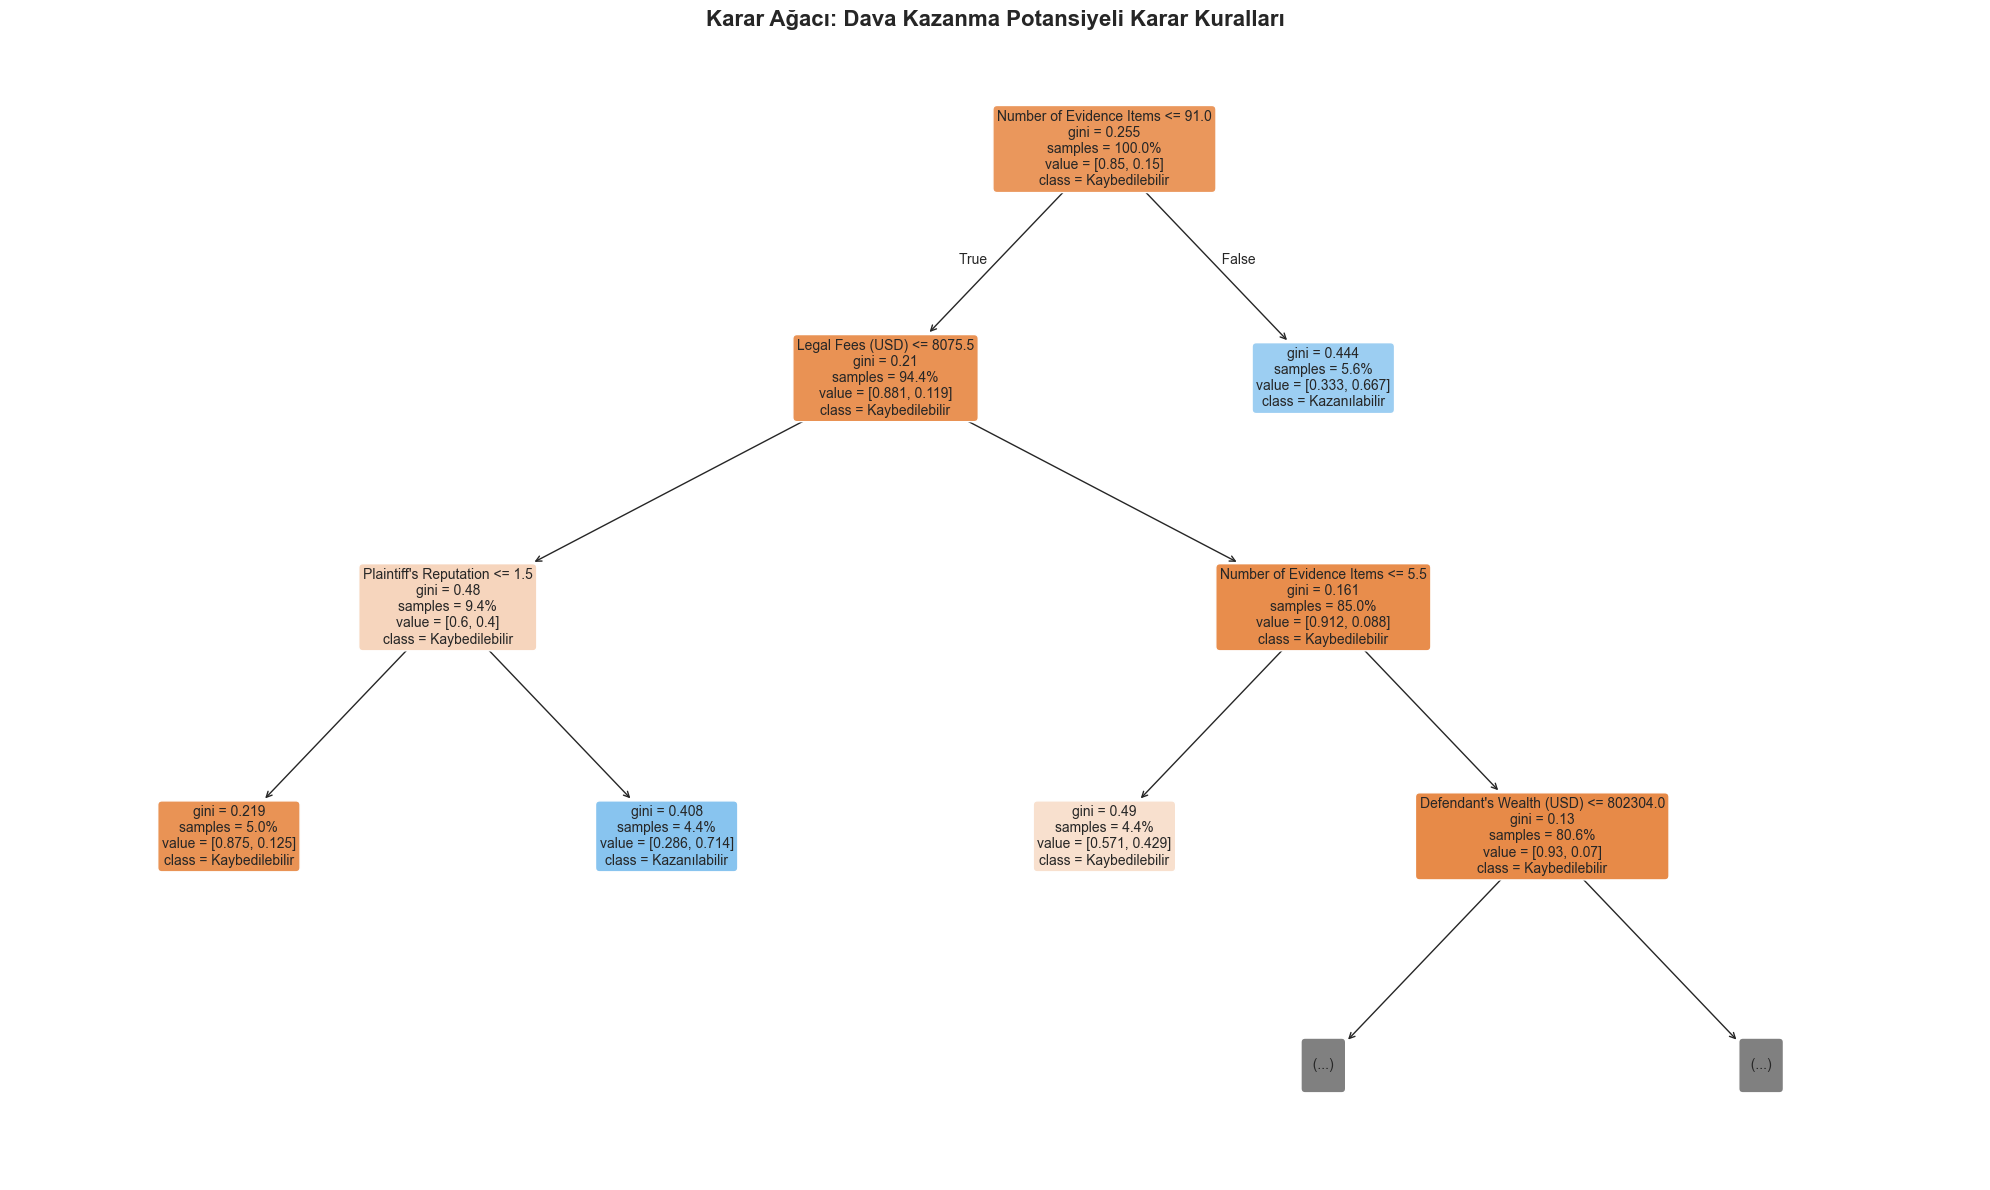

Karar Kuralları (İlk 4 Seviye):
|--- Number of Evidence Items <= 91.00
|   |--- Legal Fees (USD) <= 8075.50
|   |   |--- Plaintiff's Reputation <= 1.50
|   |   |   |--- class: 0
|   |   |--- Plaintiff's Reputation >  1.50
|   |   |   |--- class: 1
|   |--- Legal Fees (USD) >  8075.50
|   |   |--- Number of Evidence Items <= 5.50
|   |   |   |--- class: 0
|   |   |--- Number of Evidence Items >  5.50
|   |   |   |--- Defendant's Wealth (USD) <= 802304.00
|   |   |   |   |--- Case Duration (Days) <= 119.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Case Duration (Days) >  119.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- Defendant's Wealth (USD) >  802304.00
|   |   |   |   |--- Defendant's Wealth (USD) <= 831446.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Defendant's Wealth (USD) >  831446.50
|   |   |   |   |   |--- class: 0
|--- Number of Evidence Items >  91.00
|   |--- class: 1



In [17]:
# Karar Ağacı Yapısı
plt.figure(figsize=(20, 12))
plot_tree(dt_model, max_depth=3,feature_names=X.columns,class_names=['Kaybedilebilir', 'Kazanılabilir'],
          filled=True, rounded=True, fontsize=10,proportion=True)
plt.title('Karar Ağacı: Dava Kazanma Potansiyeli Karar Kuralları',fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

#### Metin Formatında Kurallar

In [18]:
# Metin formatında kurallar
agac_kurallari = export_text(dt_model, feature_names=list(X.columns), max_depth=4)
print("Karar Kuralları (İlk 4 Seviye):")
print(agac_kurallari[:5000] + "..." if len(agac_kurallari) > 5000 else agac_kurallari)
print("ANALİZ TAMAMLANDI")

Karar Kuralları (İlk 4 Seviye):
|--- Number of Evidence Items <= 91.00
|   |--- Legal Fees (USD) <= 8075.50
|   |   |--- Plaintiff's Reputation <= 1.50
|   |   |   |--- class: 0
|   |   |--- Plaintiff's Reputation >  1.50
|   |   |   |--- class: 1
|   |--- Legal Fees (USD) >  8075.50
|   |   |--- Number of Evidence Items <= 5.50
|   |   |   |--- class: 0
|   |   |--- Number of Evidence Items >  5.50
|   |   |   |--- Defendant's Wealth (USD) <= 802304.00
|   |   |   |   |--- Case Duration (Days) <= 119.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Case Duration (Days) >  119.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- Defendant's Wealth (USD) >  802304.00
|   |   |   |   |--- Defendant's Wealth (USD) <= 831446.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Defendant's Wealth (USD) >  831446.50
|   |   |   |   |   |--- class: 0
|--- Number of Evidence Items >  91.00
|   |--- class: 1

ANALİZ TAMAMLANDI
